# Multinomial Simulation Study: Poisson Count Race

In [ ]:
library(ggplot2)
library(patchwork)

theme_set(theme_minimal(base_size = 13))

# ── Core simulation engine ──────────────────────────────────────────────────
#' Simulate choice probabilities from the temperature-identified Poisson count race
#'
#' @param v   Numeric vector of systematic utilities (length K)
#' @param theta  Accumulation threshold (positive integer)
#' @param beta   Temperature (noise scale)
#' @param n_sim  Number of Monte Carlo draws
#' @return Named numeric vector of estimated choice probabilities
race_choice_probs <- function(v, theta, beta = 1, n_sim = 1e6) {
  K <- length(v)
  # Draw Gamma(theta, 1) for each alternative and each simulation
  G <- matrix(rgamma(n_sim * K, shape = theta, rate = 1), nrow = n_sim, ncol = K)
  # Standardised log-Gamma noise
  mu_theta <- digamma(theta)
  sd_theta <- sqrt(trigamma(theta))
  Z <- (-log(G) + mu_theta) / sd_theta
  # Temperature-identified utilities
  U <- sweep(Z * beta, 2, v, "+")
  # Choice = argmax
  choices <- max.col(U, ties.method = "random")
  tabulate(choices, nbins = K) / n_sim
}

#' Multinomial Logit (softmax) choice probabilities (exact)
#'
#' Under temperature identification with fixed beta, the Gumbel scale parameter
#' is b = beta * sqrt(6) / pi, so the softmax inverse temperature is
#' pi / (beta * sqrt(6)).
#' @param v   Numeric vector of systematic utilities
#' @param beta  Temperature
#' @return Numeric vector of choice probabilities
mnl_probs <- function(v, beta = 1) {
  sigma_gumbel <- pi / sqrt(6)   # SD of Gumbel(0,1)
  scaled <- v * sigma_gumbel / beta  # = v * pi / (beta * sqrt(6))
  ev <- exp(scaled - max(scaled))
  ev / sum(ev)
}

#' Multinomial Probit choice probabilities (Monte Carlo)
#'
#' Independent equal-variance Gaussian errors with scale beta.
#' @param v   Numeric vector of systematic utilities
#' @param beta  Temperature
#' @param n_sim Number of Monte Carlo draws
#' @return Numeric vector of estimated choice probabilities
mnp_probs <- function(v, beta = 1, n_sim = 1e6) {
  K <- length(v)
  Z <- matrix(rnorm(n_sim * K), nrow = n_sim, ncol = K)
  U <- sweep(Z * beta, 2, v, "+")
  choices <- max.col(U, ties.method = "random")
  tabulate(choices, nbins = K) / n_sim
}

#' Total variation distance between two probability vectors
tv_dist <- function(p, q) 0.5 * sum(abs(p - q))


# Introduction

The binary simulation in the main text demonstrates that the temperature-identified Poisson count race interpolates smoothly between Logit ($\theta = 1$) and Probit ($\theta \to \infty$) in the two-alternative case. Here we extend this analysis to the multinomial setting ($K > 2$), where the differences between logit and probit become richer and more consequential.

In the binary case, logit and probit choice functions differ only in the shape of the psychometric curve—a subtle quantitative distinction. With three or more alternatives, additional qualitative differences emerge. Most prominently, the Multinomial Logit model satisfies the *Independence of Irrelevant Alternatives* (IIA) property: the ratio of choice probabilities for any two alternatives is independent of the remaining alternatives in the choice set. The Multinomial Probit model, even with independent errors, does not share this property. The Poisson count race therefore provides a window into how IIA-like behavior gradually weakens as the noise distribution transitions from Gumbel to Gaussian.

We organise the multinomial simulations around five questions:

1.  **Convergence**: How quickly do Poisson count race choice probabilities converge to the Probit reference as $\theta$ increases, and does the rate of convergence depend on $K$?
2.  **Probability vectors**: How does the full distribution over alternatives change as $\theta$ varies from 1 to large values?
3.  **Set-size scaling**: How does the probability of choosing a target alternative scale with the number of competitors, and how does this scaling differ between logit, probit, and intermediate regimes?
4.  **Independence of Irrelevant Alternatives**: How does the IIA property—exact under logit—erode as $\theta$ increases toward the probit regime?
5.  **Parameter invariance**: When misspecified logit or probit models are fit to Poisson count race data, which model yields parameters that are invariant to $K$?

All simulations use Monte Carlo sampling with $10^6$ replications per condition unless otherwise noted.

# Study 1: Convergence to Probit

We first examine how the total variation (TV) distance between the Poisson count race choice probabilities and the Logit / Probit references changes as a function of $\theta$, for different numbers of alternatives $K$.

For each $K$, we use linearly spaced utilities $v_i = (K - i)/(K - 1)$ for $i = 1, \ldots, K$, ensuring that the best and worst alternatives always have utilities 1 and 0 regardless of $K$. The temperature is fixed at $\beta = 1$.

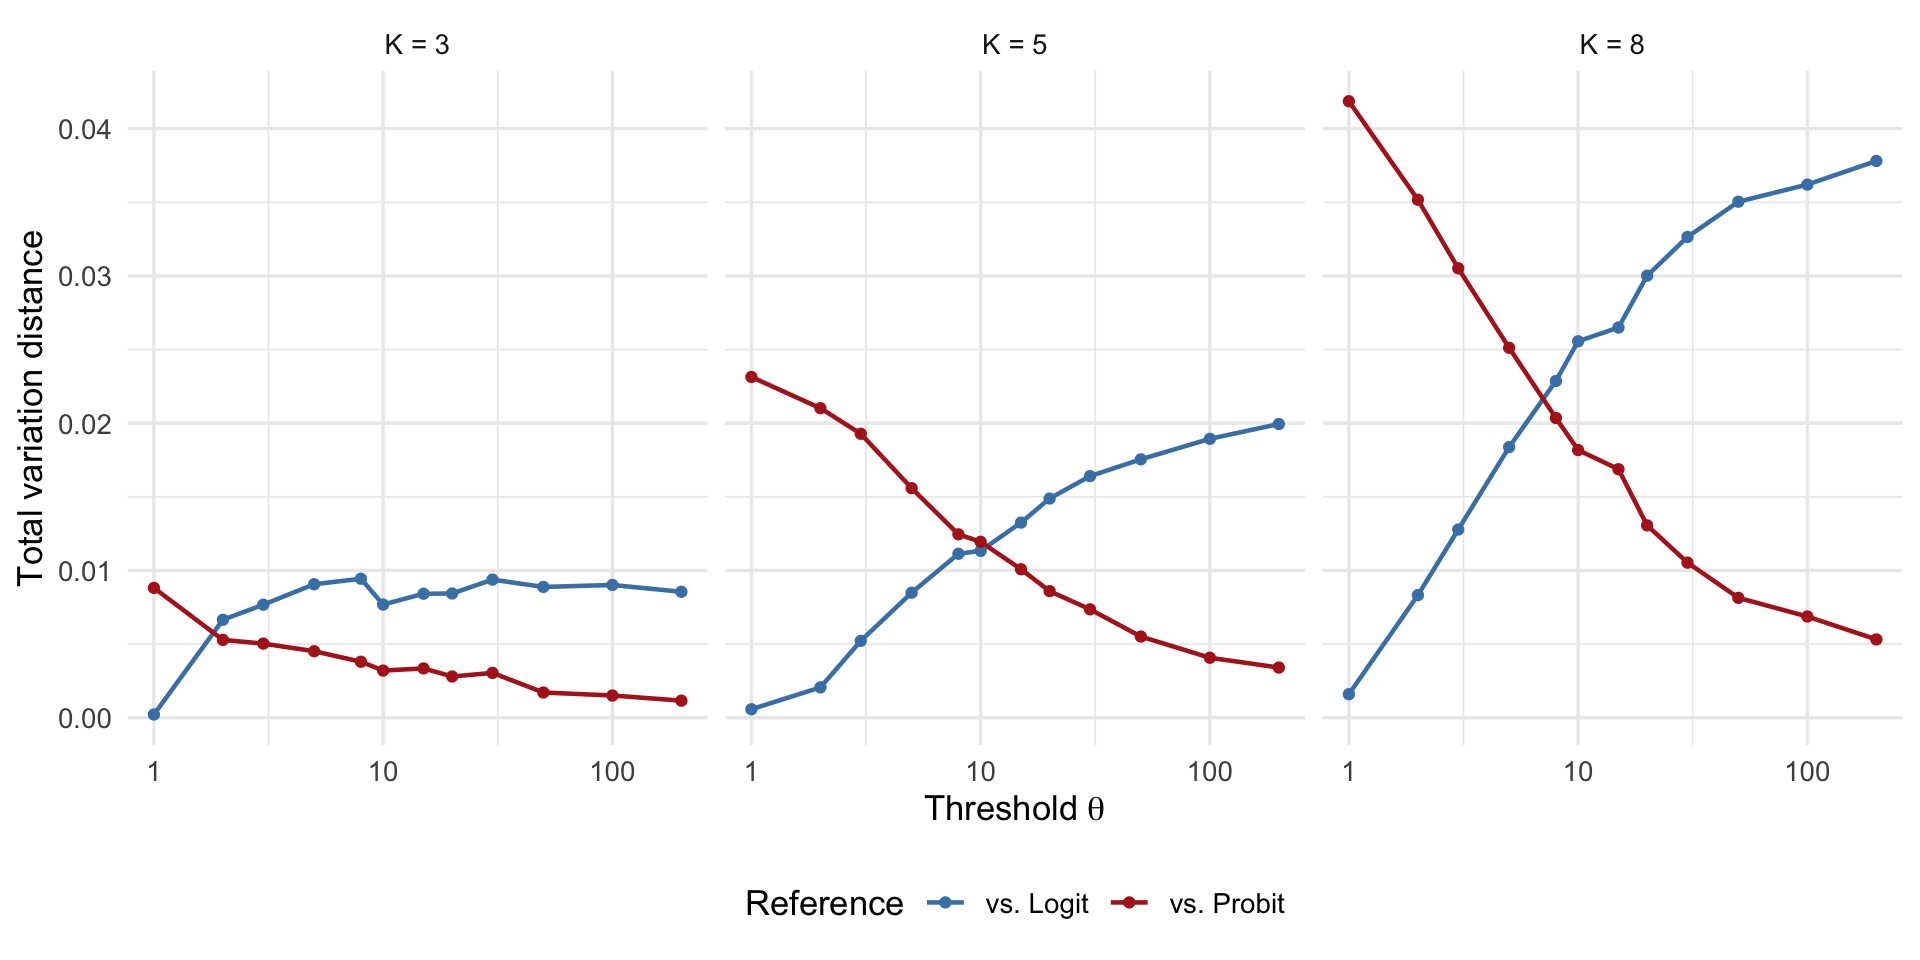

In [ ]:

set.seed(42)
n_sim <- 1e6

Ks <- c(3, 5, 8)
thetas <- c(1, 2, 3, 5, 8, 10, 15, 20, 30, 50, 100, 200)

results <- data.frame()

for (K in Ks) {
  v <- seq(1, 0, length.out = K)  # linearly spaced utilities
  
  # Reference models
  p_logit <- mnl_probs(v, beta = 1)
  p_probit <- mnp_probs(v, beta = 1, n_sim = 2e6)
  
  for (th in thetas) {
    p_race <- race_choice_probs(v, theta = th, beta = 1, n_sim = n_sim)
    
    results <- rbind(results, data.frame(
      K = K,
      theta = th,
      tv_logit = tv_dist(p_race, p_logit),
      tv_probit = tv_dist(p_race, p_probit)
    ))
  }
}

# Reshape for plotting
df_tv <- rbind(
  data.frame(K = results$K, theta = results$theta, 
             TV = results$tv_logit, Reference = "vs. Logit"),
  data.frame(K = results$K, theta = results$theta, 
             TV = results$tv_probit, Reference = "vs. Probit")
)
df_tv$K_label <- paste0("K = ", df_tv$K)
df_tv$K_label <- factor(df_tv$K_label, levels = paste0("K = ", Ks))

ggplot(df_tv, aes(x = theta, y = TV, color = Reference)) +
  geom_line(linewidth = 0.8) +
  geom_point(size = 1.5) +
  scale_x_log10() +
  facet_wrap(~K_label) +
  scale_color_manual(values = c("vs. Logit" = "steelblue", "vs. Probit" = "firebrick")) +
  labs(
    x = expression("Threshold " * theta),
    y = "Total variation distance",
    color = "Reference"
  ) +
  theme(legend.position = "bottom")


# Study 2: Choice Probability Vectors

To visualise how the full distribution over alternatives evolves with $\theta$, we fix $K = 5$ with utilities $v = (2.0,\; 1.5,\; 1.0,\; 0.5,\; 0.0)$ and plot the choice probability for each alternative across a range of thresholds.

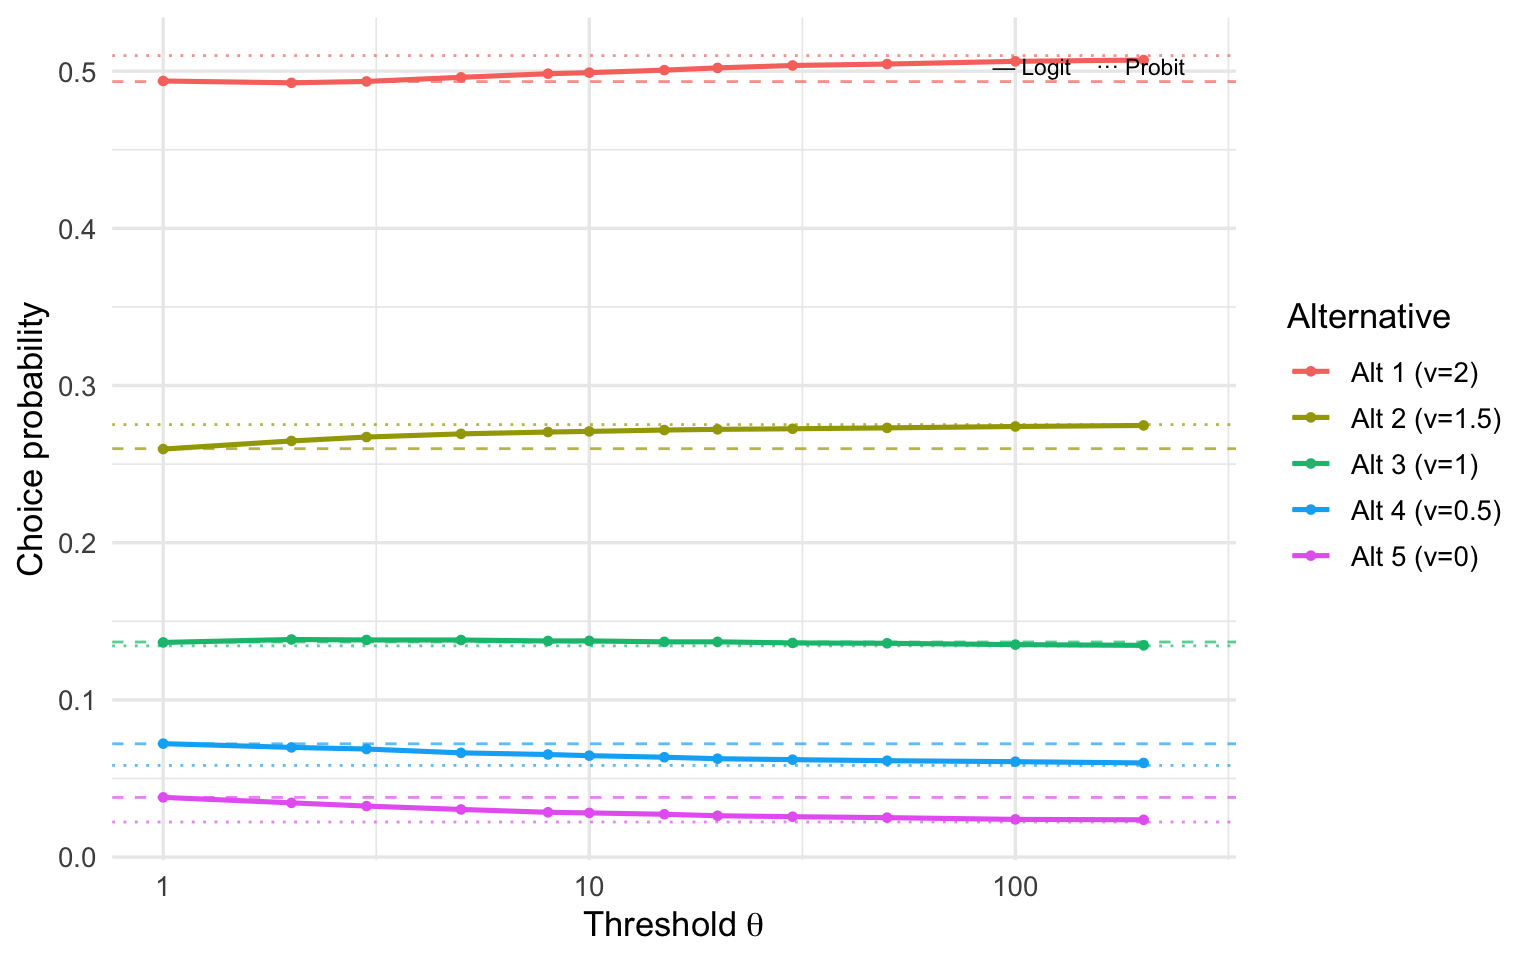

In [ ]:

set.seed(123)
K <- 5
v <- seq(2, 0, length.out = K)
thetas_fine <- c(1, 2, 3, 5, 8, 10, 15, 20, 30, 50, 100, 200)
n_sim <- 2e6

# References
p_logit <- mnl_probs(v, beta = 1)
p_probit <- mnp_probs(v, beta = 1, n_sim = 5e6)

# Race probabilities across theta
df_probs <- data.frame()
for (th in thetas_fine) {
  p <- race_choice_probs(v, theta = th, beta = 1, n_sim = n_sim)
  for (i in 1:K) {
    df_probs <- rbind(df_probs, data.frame(
      theta = th,
      alternative = paste0("Alt ", i, " (v=", v[i], ")"),
      prob = p[i]
    ))
  }
}

# Reference data
df_ref <- data.frame()
for (i in 1:K) {
  df_ref <- rbind(df_ref, data.frame(
    alternative = paste0("Alt ", i, " (v=", v[i], ")"),
    logit = p_logit[i],
    probit = p_probit[i]
  ))
}

df_probs$alternative <- factor(df_probs$alternative, 
                                levels = paste0("Alt ", 1:K, " (v=", v, ")"))
df_ref$alternative <- factor(df_ref$alternative,
                              levels = paste0("Alt ", 1:K, " (v=", v, ")"))

ggplot(df_probs, aes(x = theta, y = prob, color = alternative)) +
  geom_line(linewidth = 0.9) +
  geom_point(size = 1.2) +
  geom_hline(data = df_ref, aes(yintercept = logit, color = alternative), 
             linetype = "dashed", linewidth = 0.5, alpha = 0.7) +
  geom_hline(data = df_ref, aes(yintercept = probit, color = alternative), 
             linetype = "dotted", linewidth = 0.5, alpha = 0.7) +
  scale_x_log10() +
  labs(
    x = expression("Threshold " * theta),
    y = "Choice probability",
    color = "Alternative"
  ) +
  theme(legend.position = "right") +
  annotate("text", x = 250, y = max(p_logit) + 0.01, label = "— Logit    ··· Probit", 
           size = 3, hjust = 1)


# Study 3: Set-Size Scaling

A critical diagnostic for discriminating between logit and probit models is the effect of adding alternatives to the choice set (Robinson et al., 2023). Under MNL, the probability of choosing a target alternative with fixed utility is strictly determined by the ratio of its strength to the total strength. Under MNP, the scaling with set size differs because the probability of “winning” the maximum comparison depends on the shape of the noise distribution.

We fix a target alternative with utility $v_\text{target} = 1$ and add $K - 1$ equal competitors, each with utility $v_\text{comp} = 0$. As $K$ grows, we track the probability of choosing the target.

Under MNL, the choice probability is $P(\text{target}) = e^a / (e^a + K - 1)$, where $a = v_t \cdot \pi / (\beta \sqrt{6})$ is the effective scaled utility.

Under MNP: $P(\text{target}) = \int \phi(z) \,\Phi(v_t/\beta + z)^{K-1}\, dz$ (by symmetry of the $K - 1$ equal competitors). This integral reveals that probit’s thinner tails give the target a larger advantage over many competitors than logit’s heavier tails.

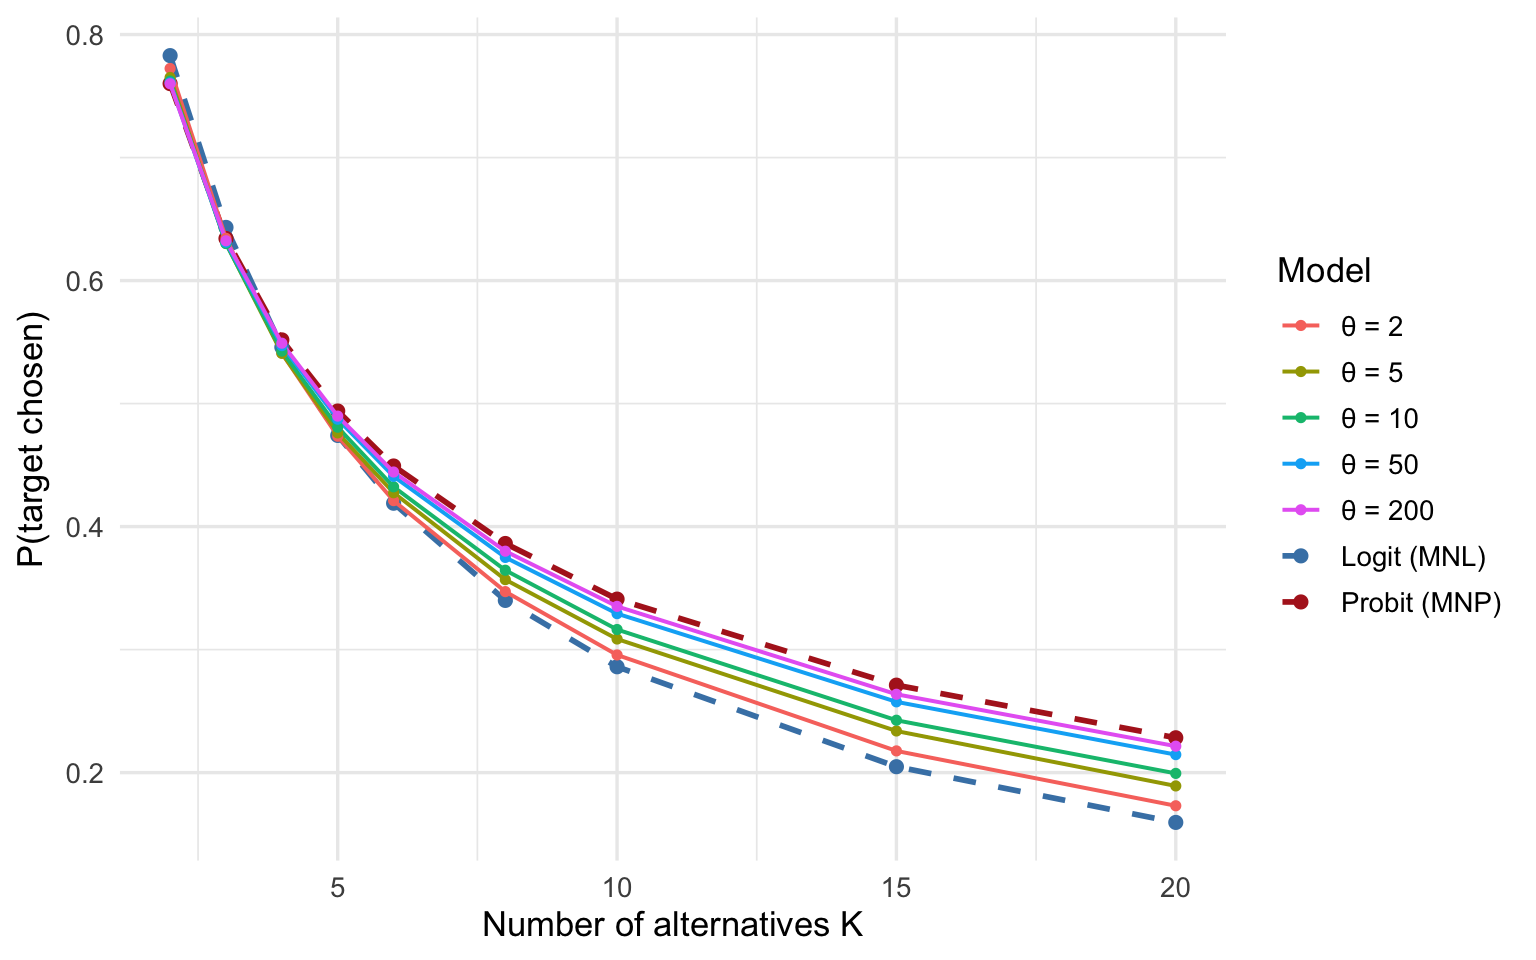

In [ ]:

set.seed(456)
n_sim <- 2e6

Ks <- c(2, 3, 4, 5, 6, 8, 10, 15, 20)
thetas_set <- c(2, 5, 10, 50, 200)

v_target <- 1
v_comp <- 0

df_setsize <- data.frame()

for (K in Ks) {
  v <- c(v_target, rep(v_comp, K - 1))
  
  # References
  p_logit_target <- mnl_probs(v, beta = 1)[1]
  p_probit_target <- mnp_probs(v, beta = 1, n_sim = n_sim)[1]
  
  df_setsize <- rbind(df_setsize, data.frame(
    K = K, theta = NA, prob = p_logit_target, model = "Logit (MNL)"
  ))
  df_setsize <- rbind(df_setsize, data.frame(
    K = K, theta = NA, prob = p_probit_target, model = "Probit (MNP)"
  ))
  
  for (th in thetas_set) {
    p_race <- race_choice_probs(v, theta = th, beta = 1, n_sim = n_sim)
    df_setsize <- rbind(df_setsize, data.frame(
      K = K, theta = th, prob = p_race[1], model = paste0("θ = ", th)
    ))
  }
}

# Separate reference and race data
df_ref_lines <- df_setsize[df_setsize$model %in% c("Logit (MNL)", "Probit (MNP)"), ]
df_race_lines <- df_setsize[!df_setsize$model %in% c("Logit (MNL)", "Probit (MNP)"), ]

df_race_lines$model <- factor(df_race_lines$model, 
                               levels = paste0("θ = ", thetas_set))

ggplot() +
  geom_line(data = df_ref_lines, aes(x = K, y = prob, color = model), 
            linetype = "dashed", linewidth = 1) +
  geom_point(data = df_ref_lines, aes(x = K, y = prob, color = model), size = 2) +
  geom_line(data = df_race_lines, aes(x = K, y = prob, group = model, color = model), 
            linewidth = 0.7) +
  geom_point(data = df_race_lines, aes(x = K, y = prob, color = model), size = 1.3) +
  scale_color_manual(
    values = c(
      "Logit (MNL)" = "steelblue",
      "Probit (MNP)" = "firebrick",
      setNames(scales::hue_pal()(length(thetas_set)), paste0("θ = ", thetas_set))
    )
  ) +
  labs(
    x = "Number of alternatives K",
    y = expression("P(target chosen)"),
    color = "Model"
  ) +
  theme(legend.position = "right")


# Study 4: Independence of Irrelevant Alternatives

The IIA property is a hallmark of the Multinomial Logit model: the ratio of choice probabilities for any two alternatives is invariant to the composition of the choice set. Formally, for alternatives $i$ and $j$:

$$\frac{P(i \mid \mathcal{C})}{P(j \mid \mathcal{C})} = \frac{e^{v_i}}{e^{v_j}} \quad \text{for all choice sets } \mathcal{C} \ni i, j$$

This property does not hold for the Multinomial Probit model, even when errors are independent and identically distributed. The Poisson count race therefore provides a mechanism through which IIA holds exactly at $\theta = 1$ and is progressively violated as $\theta$ increases.

To quantify this, we consider three alternatives with utilities $v = (2, 1, 0)$. We compute the ratio $P(1)/P(2)$ under two conditions:

-   **Full set**: all three alternatives present $\{1, 2, 3\}$
-   **Reduced set**: only alternatives $\{1, 2\}$ present

Under IIA, these ratios should be identical. We track the percentage change in the ratio as $\theta$ varies.

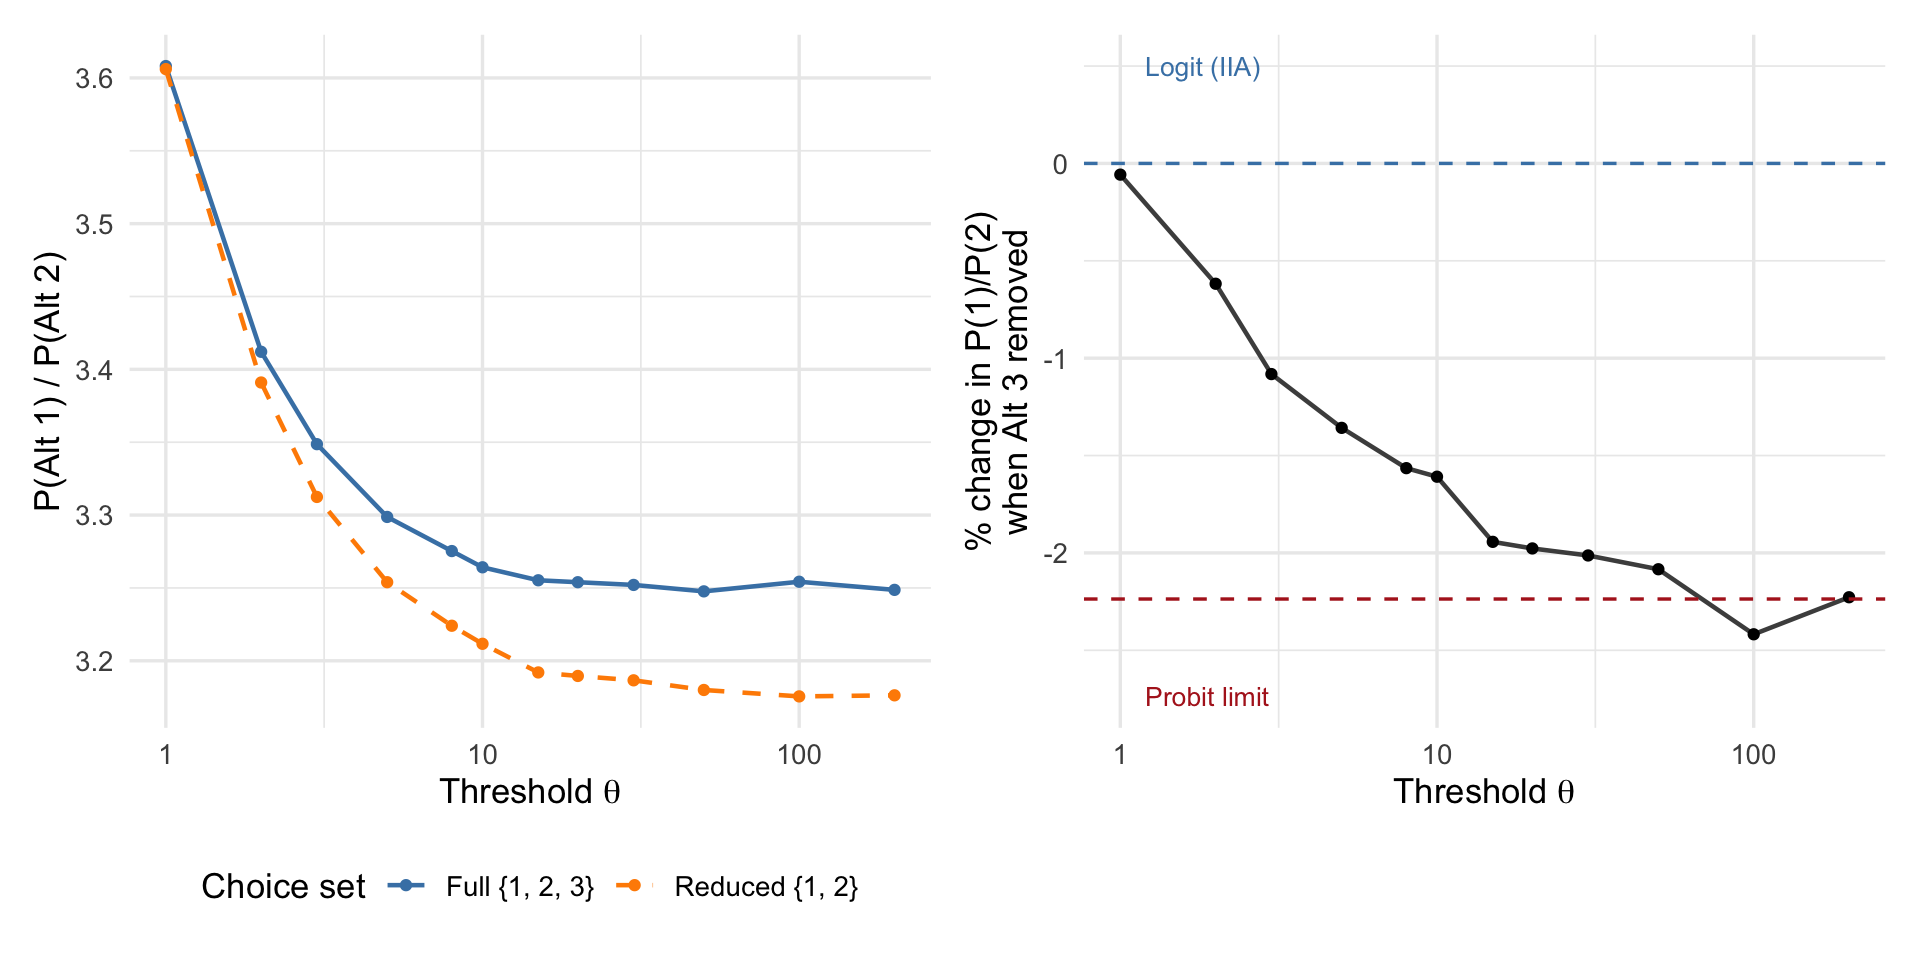

In [ ]:

set.seed(789)
n_sim <- 5e6

v_full <- c(2, 1, 0)
v_reduced <- c(2, 1)

thetas_iia <- c(1, 2, 3, 5, 8, 10, 15, 20, 30, 50, 100, 200)

df_iia <- data.frame()

for (th in thetas_iia) {
  # Full set {1, 2, 3}
  p_full <- race_choice_probs(v_full, theta = th, beta = 1, n_sim = n_sim)
  ratio_full <- p_full[1] / p_full[2]
  
  # Reduced set {1, 2}
  p_reduced <- race_choice_probs(v_reduced, theta = th, beta = 1, n_sim = n_sim)
  ratio_reduced <- p_reduced[1] / p_reduced[2]
  
  df_iia <- rbind(df_iia, data.frame(
    theta = th,
    ratio_full = ratio_full,
    ratio_reduced = ratio_reduced,
    pct_change = 100 * (ratio_reduced - ratio_full) / ratio_full
  ))
}

# Also compute reference values
p_logit_full <- mnl_probs(v_full)[1] / mnl_probs(v_full)[2]
p_logit_reduced <- mnl_probs(v_reduced)[1] / mnl_probs(v_reduced)[2]

p_probit_full <- mnp_probs(v_full, n_sim = 5e6)
r_probit_full <- p_probit_full[1] / p_probit_full[2]
p_probit_reduced <- mnp_probs(v_reduced, n_sim = 5e6)
r_probit_reduced <- p_probit_reduced[1] / p_probit_reduced[2]
probit_pct <- 100 * (r_probit_reduced - r_probit_full) / r_probit_full

# Left panel: ratios
df_ratios <- rbind(
  data.frame(theta = df_iia$theta, ratio = df_iia$ratio_full, 
             set = "Full {1, 2, 3}"),
  data.frame(theta = df_iia$theta, ratio = df_iia$ratio_reduced, 
             set = "Reduced {1, 2}")
)

p1 <- ggplot(df_ratios, aes(x = theta, y = ratio, color = set, linetype = set)) +
  geom_line(linewidth = 0.8) +
  geom_point(size = 1.5) +
  scale_x_log10() +
  scale_linetype_manual(values = c("Full {1, 2, 3}" = "solid", "Reduced {1, 2}" = "dashed")) +
  scale_color_manual(values = c("Full {1, 2, 3}" = "steelblue", "Reduced {1, 2}" = "darkorange")) +
  labs(
    x = expression("Threshold " * theta),
    y = "P(Alt 1) / P(Alt 2)",
    color = "Choice set",
    linetype = "Choice set"
  ) +
  theme(legend.position = "bottom")

# Right panel: IIA violation
p2 <- ggplot(df_iia, aes(x = theta, y = pct_change)) +
  geom_line(linewidth = 0.8, color = "grey30") +
  geom_point(size = 1.5) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "steelblue", linewidth = 0.6) +
  geom_hline(yintercept = probit_pct, linetype = "dashed", color = "firebrick", linewidth = 0.6) +
  annotate("text", x = 1.2, y = 0.5, label = "Logit (IIA)", color = "steelblue", 
           hjust = 0, size = 3.5) +
  annotate("text", x = 1.2, y = probit_pct - 0.5, label = "Probit limit", color = "firebrick", 
           hjust = 0, size = 3.5) +
  scale_x_log10() +
  labs(
    x = expression("Threshold " * theta),
    y = "% change in P(1)/P(2)\nwhen Alt 3 removed"
  )

p1 + p2 + plot_layout(widths = c(1, 1))


# Study 5: Parameter Invariance Across Set Size

A key empirical diagnostic for distinguishing between logit and probit is parameter invariance across changes in set size $K$ (Robinson et al., 2023). If choice data are generated by a logit model, the softmax inverse temperature $\beta_{\text{logit}}$ recovered from fitting a logit specification should remain constant as $K$ increases. Conversely, if the data follow a probit model, the Gaussian noise scale $\beta_{\text{probit}}$ should be invariant to $K$.

We test this directly. For each value of $\theta$ and each set size $K$ (with a target at $v = 1$ vs. $K-1$ equal competitors at $v = 0$), we compute the “true” choice probability $P(\text{target})$ from the race model and then recover the best-fitting logit and probit temperature parameters by inversion.

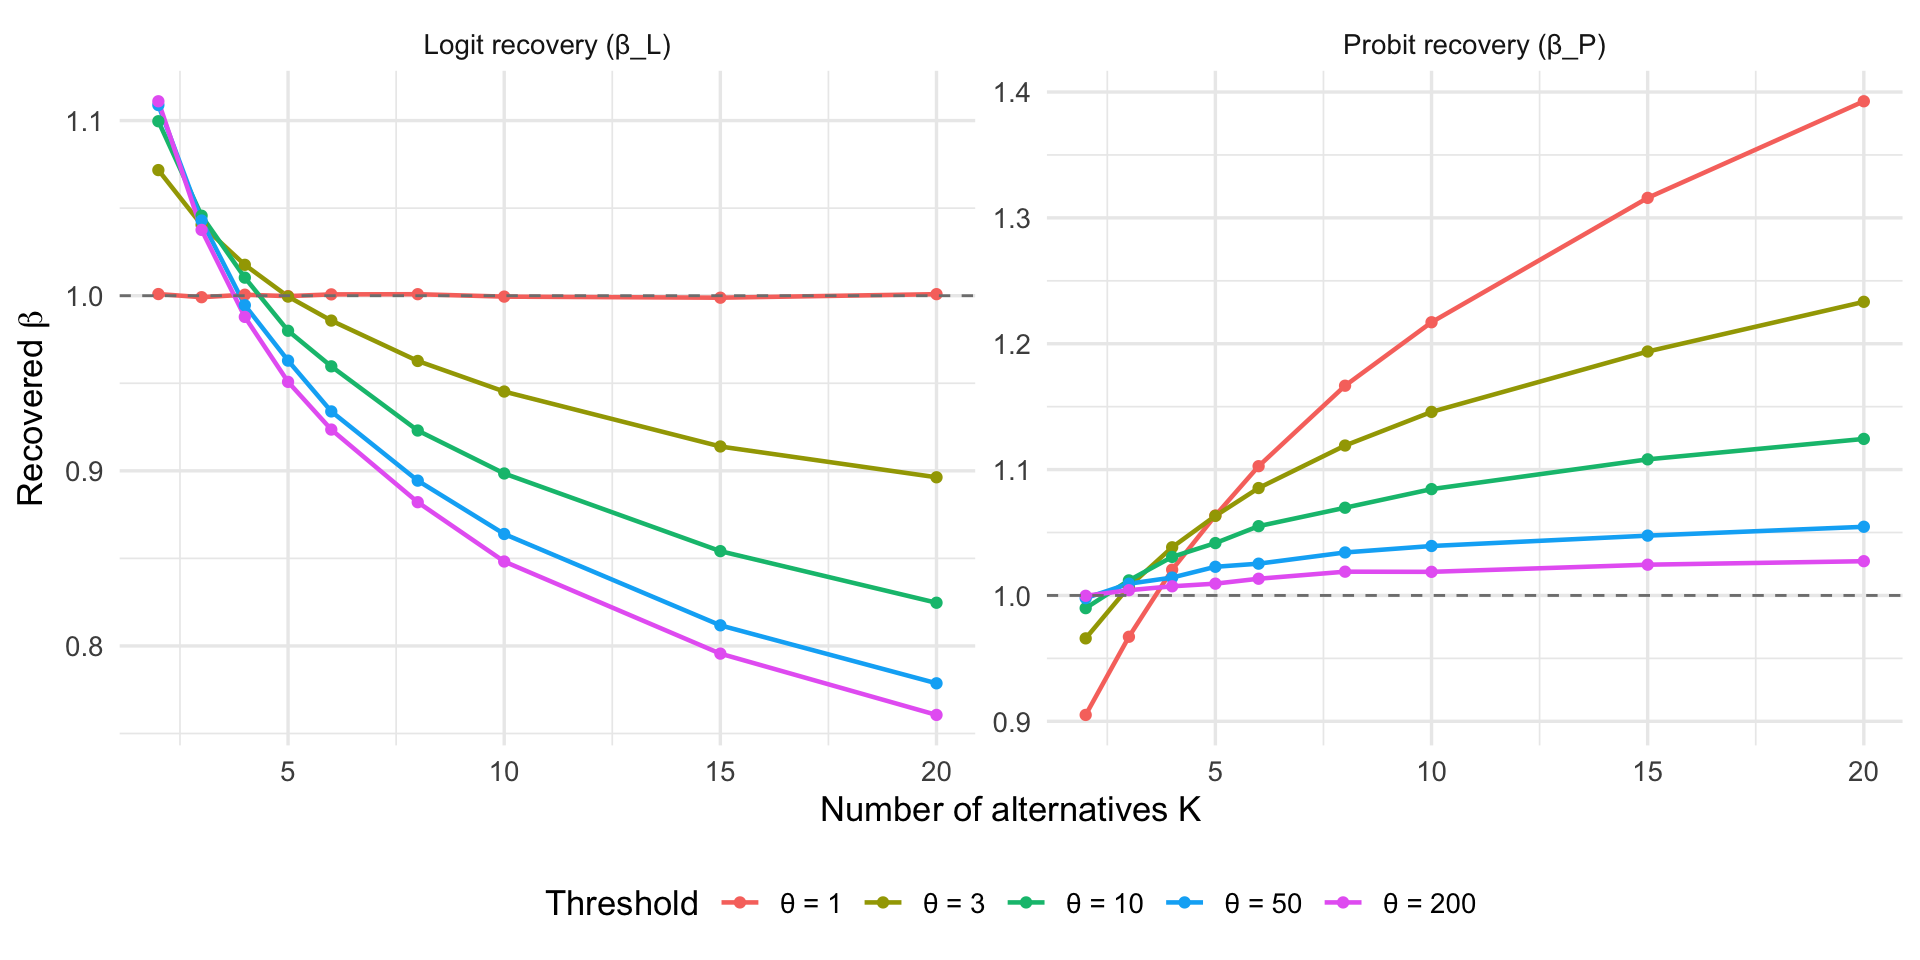

In [ ]:

set.seed(303)
n_sim <- 3e6

Ks_param <- c(2, 3, 4, 5, 6, 8, 10, 15, 20)
thetas_param <- c(1, 3, 10, 50, 200)
v_target <- 1
sigma_G <- pi / sqrt(6)

# Helper: probit P(target) for symmetric case (1 target vs K-1 equal competitors)
probit_target_prob <- function(v_t, beta, K) {
  integrand <- function(z) dnorm(z) * pnorm(v_t / beta + z)^(K - 1)
  integrate(integrand, -10, 10, rel.tol = 1e-10)$value
}

# Recover logit beta from observed P(target)
recover_logit_beta <- function(p_target, v_t, K) {
  if (p_target <= 1/K || p_target >= 1) return(NA_real_)
  a <- log(p_target * (K - 1) / (1 - p_target))
  if (a <= 0) return(NA_real_)
  v_t * sigma_G / a
}

# Recover probit beta from observed P(target) via root-finding
recover_probit_beta <- function(p_target, v_t, K) {
  if (p_target <= 1/K || p_target >= 1) return(NA_real_)
  f <- function(log_beta) probit_target_prob(v_t, exp(log_beta), K) - p_target
  tryCatch({
    root <- uniroot(f, interval = c(log(0.01), log(50)), tol = 1e-8)
    exp(root$root)
  }, error = function(e) NA_real_)
}

df_param <- data.frame()

for (th in thetas_param) {
  for (K in Ks_param) {
    v <- c(v_target, rep(0, K - 1))
    p_race <- race_choice_probs(v, theta = th, beta = 1, n_sim = n_sim)[1]
    
    beta_logit <- recover_logit_beta(p_race, v_target, K)
    beta_probit <- recover_probit_beta(p_race, v_target, K)
    
    df_param <- rbind(df_param, data.frame(
      K = K, theta = th, 
      beta_logit = beta_logit, 
      beta_probit = beta_probit,
      model_label = paste0("θ = ", th)
    ))
  }
}

df_param$model_label <- factor(df_param$model_label, 
                                levels = paste0("θ = ", thetas_param))

# Reshape for faceting
df_param_long <- rbind(
  data.frame(K = df_param$K, theta_label = df_param$model_label,
             beta = df_param$beta_logit, recovery = "Logit recovery (β_L)"),
  data.frame(K = df_param$K, theta_label = df_param$model_label,
             beta = df_param$beta_probit, recovery = "Probit recovery (β_P)")
)

ggplot(df_param_long, aes(x = K, y = beta, color = theta_label)) +
  geom_line(linewidth = 0.8) +
  geom_point(size = 1.5) +
  geom_hline(yintercept = 1, linetype = "dashed", color = "grey50", linewidth = 0.5) +
  facet_wrap(~recovery, scales = "free_y") +
  labs(
    x = "Number of alternatives K",
    y = expression("Recovered " * beta),
    color = "Threshold"
  ) +
  theme(legend.position = "bottom")


# Study 6: Distributional Shape — Noise Skewness and Kurtosis

The log-Gamma noise distribution transitions from highly skewed (Gumbel, $\theta = 1$) to symmetric (Gaussian, $\theta \to \infty$). This transition in distributional shape underlies all the choice-level phenomena documented above. To make this explicit, we plot the standardised noise density for several values of $\theta$ alongside the standard normal reference.

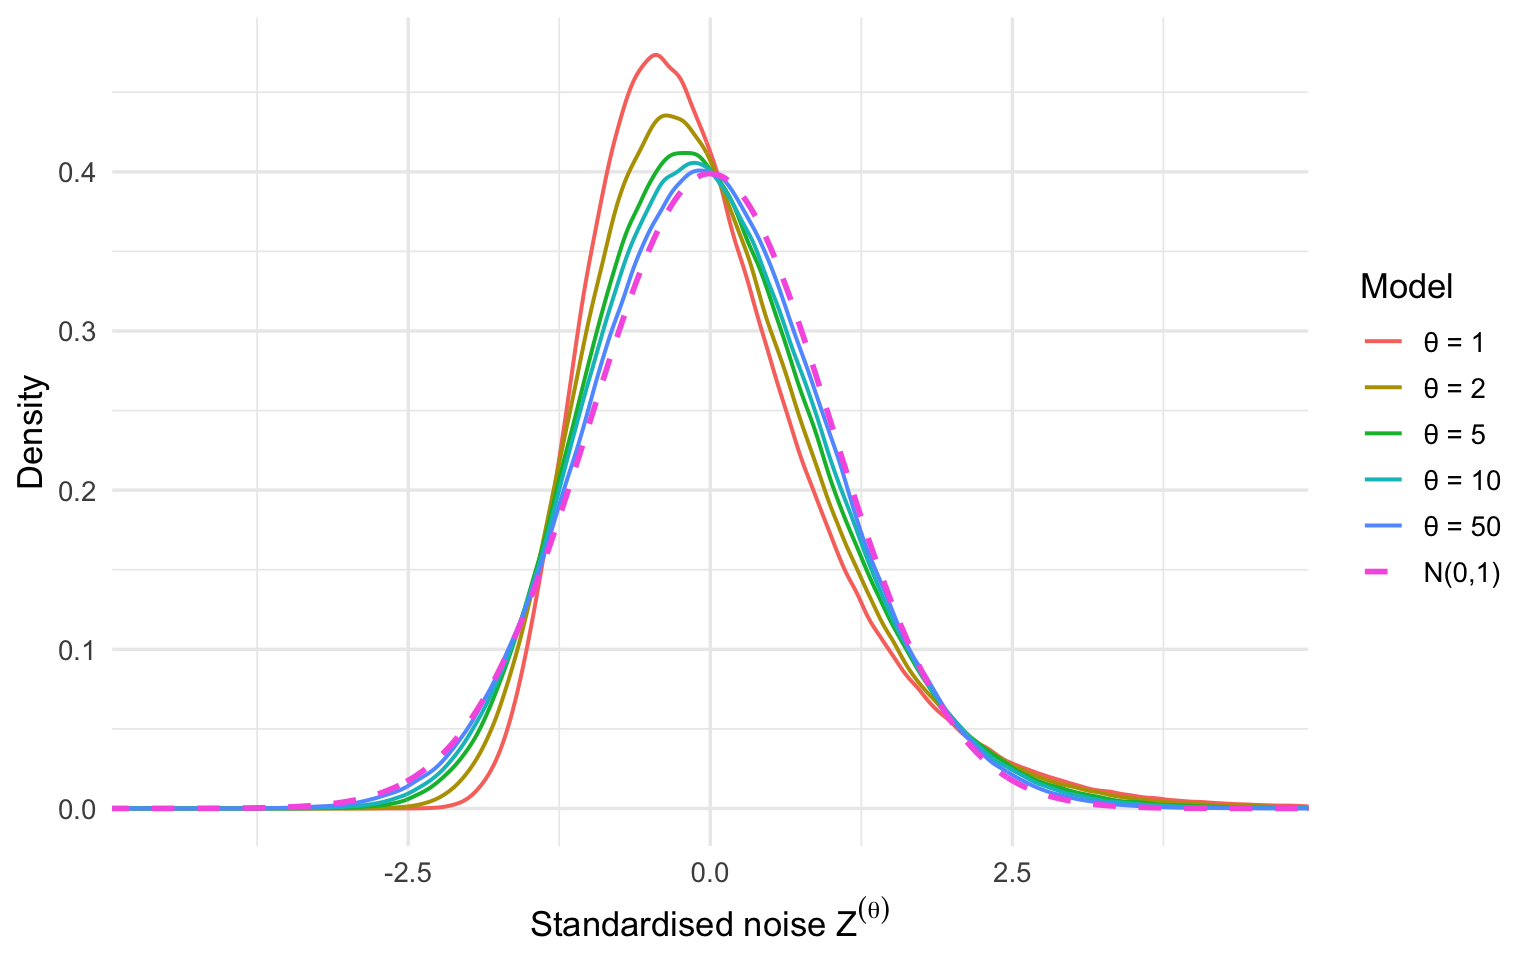

In [ ]:

set.seed(101)
n_draw <- 1e6

thetas_dens <- c(1, 2, 5, 10, 50)

df_dens <- data.frame()

for (th in thetas_dens) {
  G <- rgamma(n_draw, shape = th, rate = 1)
  eps <- -log(G)
  Z <- (eps + digamma(th)) / sqrt(trigamma(th))  # note: +digamma because E[eps] = -digamma
  # Use density estimation
  d <- density(Z, from = -5, to = 5, n = 512)
  df_dens <- rbind(df_dens, data.frame(
    x = d$x, y = d$y, 
    model = paste0("θ = ", th)
  ))
}

# Normal reference
x_norm <- seq(-5, 5, length.out = 512)
df_dens <- rbind(df_dens, data.frame(
  x = x_norm, y = dnorm(x_norm), model = "N(0,1)"
))

df_dens$model <- factor(df_dens$model, 
                         levels = c(paste0("θ = ", thetas_dens), "N(0,1)"))

ggplot(df_dens, aes(x = x, y = y, color = model, linetype = model, linewidth = model)) +
  geom_line() +
  scale_linetype_manual(
    values = c(setNames(rep("solid", length(thetas_dens)), paste0("θ = ", thetas_dens)),
               "N(0,1)" = "dashed")
  ) +
  scale_linewidth_manual(
    values = c(setNames(rep(0.7, length(thetas_dens)), paste0("θ = ", thetas_dens)),
               "N(0,1)" = 1.0)
  ) +
  labs(
    x = expression("Standardised noise " * Z^(theta)),
    y = "Density",
    color = "Model", linetype = "Model", linewidth = "Model"
  ) +
  coord_cartesian(xlim = c(-4.5, 4.5)) +
  theme(legend.position = "right")


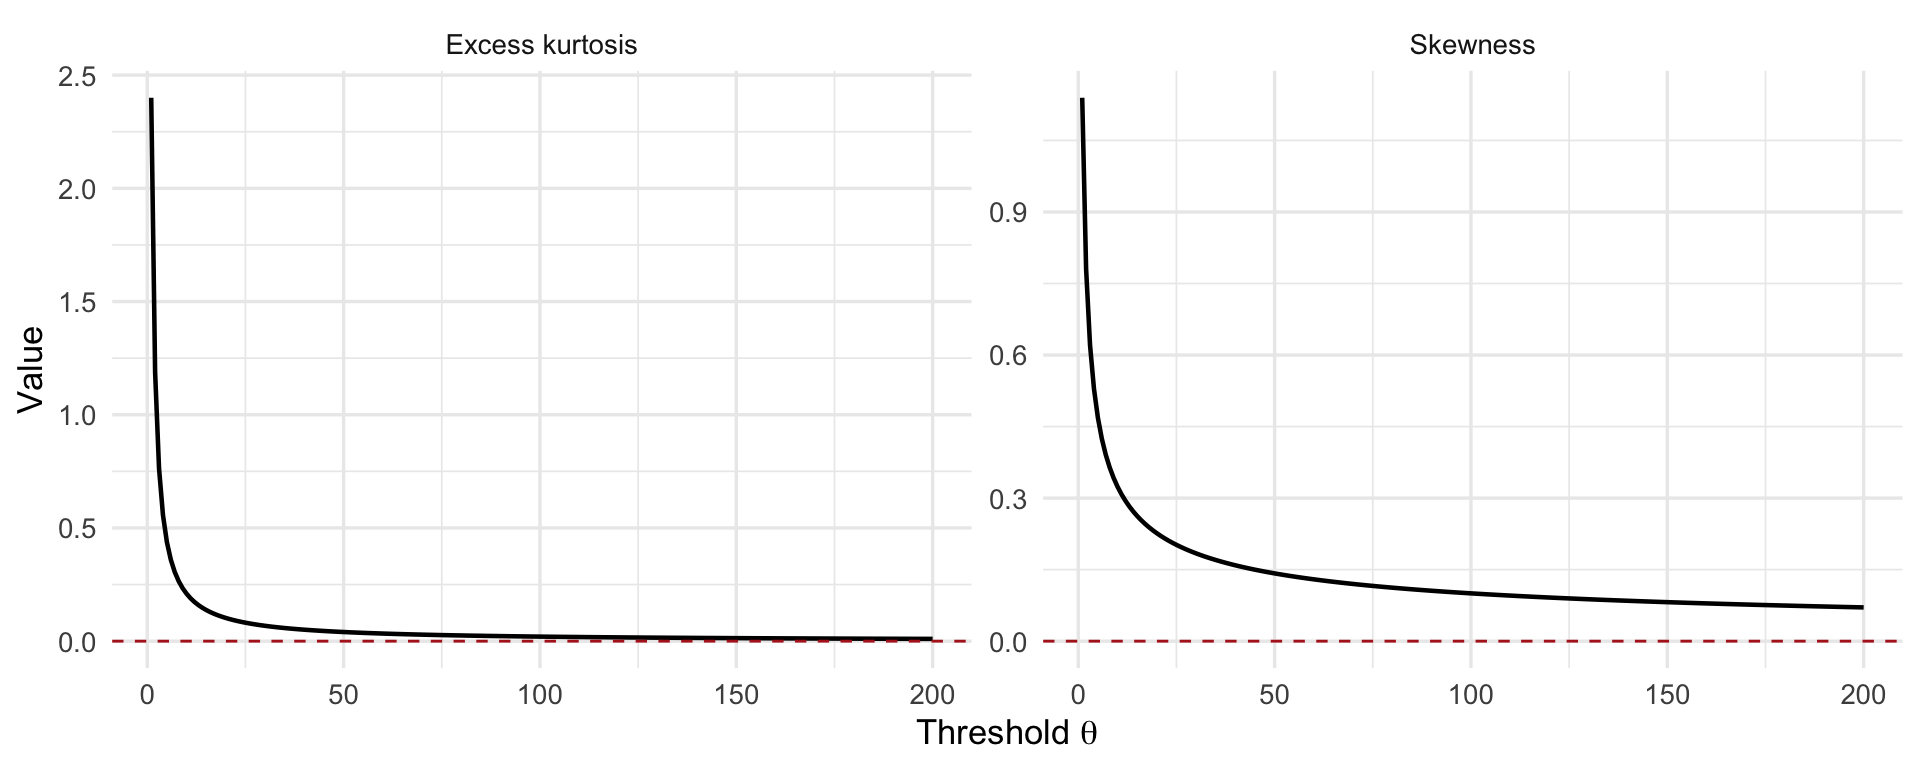

In [ ]:

# Exact skewness and kurtosis of -log(Gamma(theta,1)), standardised
# Skewness = psi_2(theta) / psi_1(theta)^(3/2) where psi_2 is the tetragamma
# Excess kurtosis = psi_3(theta) / psi_1(theta)^2 where psi_3 is the pentagamma
# Note: psigamma(x, deriv=n) gives the n-th derivative of log Gamma
# psi_1 = trigamma, psi_2 = psigamma(,2), psi_3 = psigamma(,3)

thetas_moments <- seq(1, 200, by = 1)

skewness <- -psigamma(thetas_moments, deriv = 2) / trigamma(thetas_moments)^(3/2)
# Note: -log(G) has skewness = -psi_2 / psi_1^{3/2} (the negative sign because of -log)
# Actually: let's be careful. For X = -log(G), E[(X-mu)^3] = -psi_2(theta)
# and Var(X) = psi_1(theta), so skewness = -psi_2(theta) / psi_1(theta)^{3/2}

# Excess kurtosis: E[(X-mu)^4]/Var^2 - 3 = psi_3(theta)/psi_1(theta)^2
ex_kurtosis <- psigamma(thetas_moments, deriv = 3) / trigamma(thetas_moments)^2

df_moments <- rbind(
  data.frame(theta = thetas_moments, value = skewness, moment = "Skewness"),
  data.frame(theta = thetas_moments, value = ex_kurtosis, moment = "Excess kurtosis")
)

ggplot(df_moments, aes(x = theta, y = value)) +
  geom_line(linewidth = 0.8) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "firebrick") +
  facet_wrap(~moment, scales = "free_y") +
  labs(
    x = expression("Threshold " * theta),
    y = "Value"
  )


# Study 7: Robustness Across Utility Structures

The preceding studies used specific utility vectors. To assess robustness, we examine whether the convergence pattern holds across different utility configurations that are common in psychological experiments.

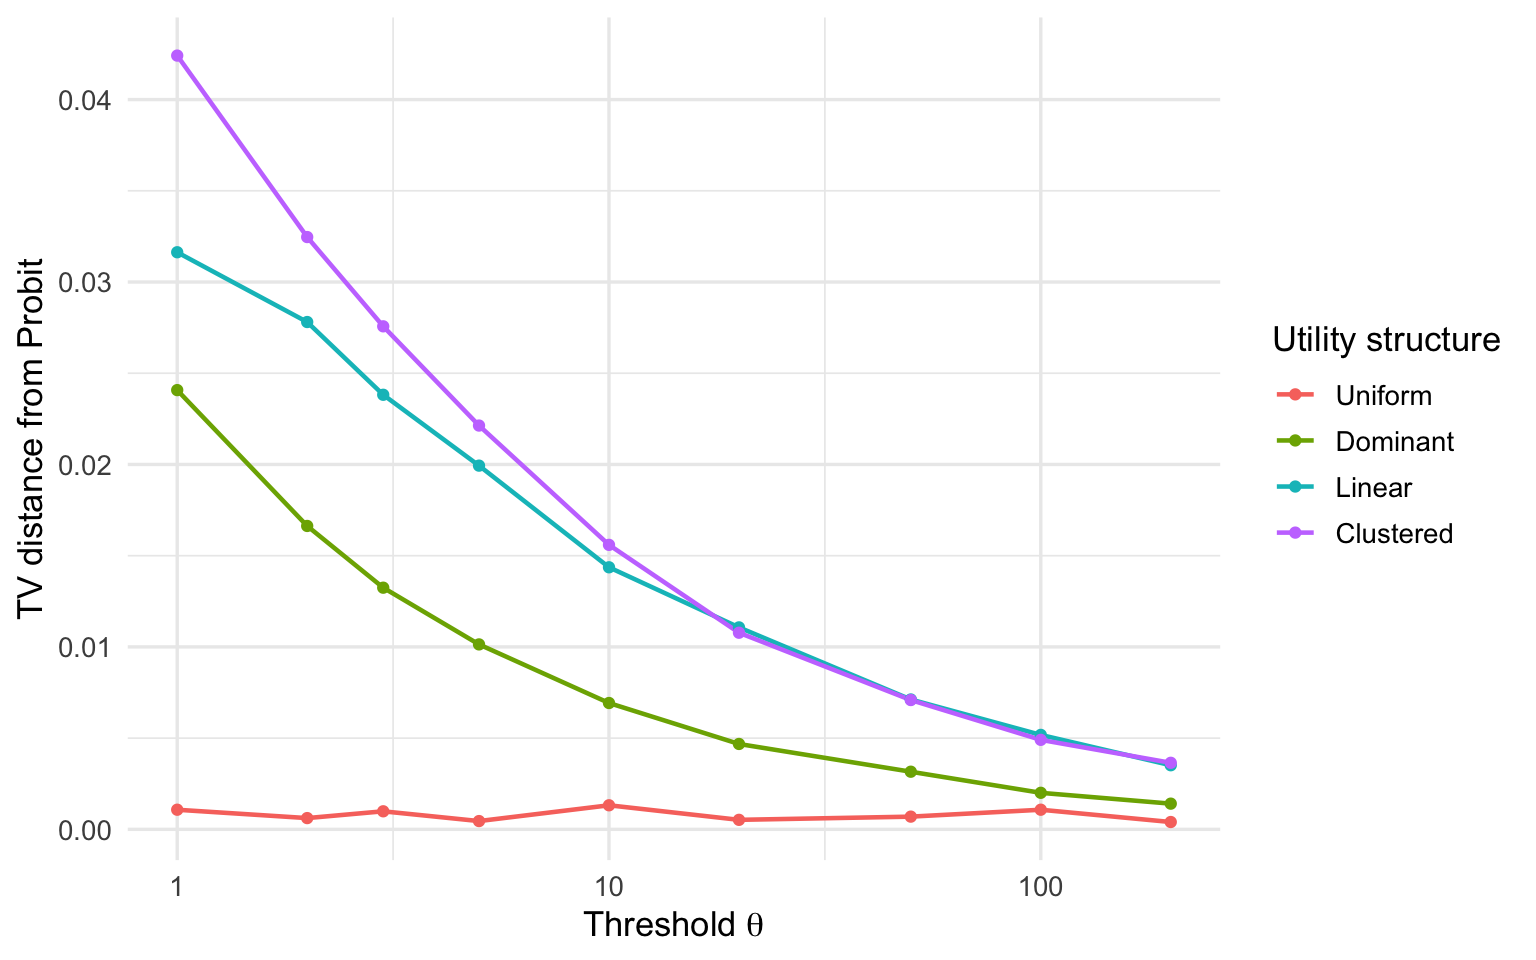

In [ ]:

set.seed(202)
n_sim <- 2e6
K <- 5

configs <- list(
  "Uniform" = rep(0, K),
  "Dominant" = c(3, rep(0, K - 1)),
  "Linear" = seq(2, 0, length.out = K),
  "Clustered" = c(2.0, 1.9, 0.1, 0.0, 0.0)
)

thetas_robust <- c(1, 2, 3, 5, 10, 20, 50, 100, 200)

df_robust <- data.frame()

for (cfg_name in names(configs)) {
  v <- configs[[cfg_name]]
  p_probit <- mnp_probs(v, beta = 1, n_sim = 5e6)
  
  for (th in thetas_robust) {
    p_race <- race_choice_probs(v, theta = th, beta = 1, n_sim = n_sim)
    df_robust <- rbind(df_robust, data.frame(
      theta = th,
      tv_probit = tv_dist(p_race, p_probit),
      config = cfg_name
    ))
  }
}

df_robust$config <- factor(df_robust$config, levels = names(configs))

ggplot(df_robust, aes(x = theta, y = tv_probit, color = config)) +
  geom_line(linewidth = 0.8) +
  geom_point(size = 1.5) +
  scale_x_log10() +
  labs(
    x = expression("Threshold " * theta),
    y = "TV distance from Probit",
    color = "Utility structure"
  ) +
  theme(legend.position = "right")


# Summary

These multinomial simulations confirm and extend the binary-case results:

1.  **Convergence is rapid and universal**: Across different values of $K$ and different utility structures, the Poisson count race converges to the Multinomial Probit reference within $\theta \approx 20$–$50$ in total variation distance.

2.  **Probability redistribution**: As $\theta$ increases, the probit model concentrates more probability on the best alternative and less on inferior alternatives, reflecting the thinner tails of Gaussian noise relative to Gumbel.

3.  **Set-size scaling**: The logit and probit models predict systematically different scaling of target choice probability with the number of competitors. The Poisson count race interpolates between these two patterns, connecting to the empirical findings of Robinson et al. (2023).

4.  **IIA erosion**: The Independence of Irrelevant Alternatives property, which holds exactly at $\theta = 1$, is progressively violated as $\theta$ increases. This provides a process-level account of why IIA holds for logit but not probit: it is a consequence of the Gumbel noise shape, and alternative noise shapes—induced by higher accumulation thresholds—do not preserve it.

5.  **Parameter invariance**: When choice data generated by the Poisson count race are fit under a logit assumption, the recovered inverse temperature drifts with set size $K$ for all $\theta > 1$. Conversely, when fit under a probit assumption, the recovered noise scale remains stable for large $\theta$ but drifts when $\theta$ is small. This cross-over in parameter invariance provides a process-level account of the empirical findings of Robinson et al. (2023): parameter stability across $K$ is diagnostic of whether the effective noise distribution is closer to Gumbel or Gaussian.

6.  **Noise shape transition**: The underlying mechanism is a smooth transition in the shape of the standardised noise distribution, from the skewed Gumbel ($\theta = 1$) to the symmetric Gaussian ($\theta \to \infty$). The skewness and kurtosis decay at known rates, providing analytic control over the approximation quality.